This code builds Latent Dirichlet Allocation (LDA) and NMF models from cleaned tweet data (in the sample_tweet_data tsv). I have only included the code that runs the models and plots the topic clusters, as the code that streams and cleans the tweets was written before this class started. To run, be sure to load each cell, and then run the cell down that contains the call to the lda_analysis and nmf_analysis functions. The matplotlib plots will be automatically generated. If you want to generate an interactive plotly plot, load and run the next set of cells after you have run the cells that build the models.  

In [5]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation 

In [6]:
"""
Topic modeling on time series data
Sample call from commandline:
python topic_modeling.py --path ~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_rights_guncontrol_converted_tweets.tsv
"""


def nmf_analysis(data, optimize = True, n_topics = None):
    """
    Vectorize tweet data into a tfidf matrix. Run NMF on the matrix. If optimize = True, 
    grid search will report out model's performance as the number of topics change.
    http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
    """
    
    n_features = 1000 
    n_top_words = 10

    tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, max_features=n_features, stop_words='english')
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    # term frequency * inverse document frequency

    tfidf = tfidf_vectorizer.fit_transform(data['filtered_text'])
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    # Optimize:
    if optimize == True:
        data = grid_search(tfidf, tfidf_feature_names, data, "NMF")
        return data, topics
    
    else:
        print("Building model...")
        nmf = NMF(n_components = n_topics, random_state = 0).fit(tfidf)
        nmf_transform = nmf.transform(tfidf)
        error = nmf.reconstruction_err_
        print("Frobenius norm: {}".format(error))
        topics = display_topics(nmf, tfidf_feature_names, n_top_words)
        
        nmf_keys = []
        for i in range(nmf_transform.shape[0]):
            nmf_keys.append(nmf_transform[i].argmax()) # Change to string so label types can be consistent for plotting
        
        data['labels'] = pd.Series(nmf_keys)
        tsne_data = run_tsne(nmf_transform)
        data['x'] = pd.Series(tsne_data[:, 0])
        data['y'] = pd.Series(tsne_data[:, 1])
        
        visualize_mpl(tweet_dataframe, topics, error, "NMF")
        
        return data, topics
        
def lda_analysis(data, optimize = True, n_topics = None):
    """ 
    Vectorize tweet data and run LDA. If optimize = True, grid search will run and report perplexity 
    of the model as the number of topics changes.
    LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    """

    n_features = 1000 
    n_top_words = 10

    tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features = n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(data['filtered_text'])
    tf_feature_names = tf_vectorizer.get_feature_names()
    
    if optimize == True:
        # Find optimal number of components
        data = grid_search(tf, tf_feature_names, data, "LDA")
        return data, topics
        
    else:
        lda = LatentDirichletAllocation(n_components = n_topics, learning_method = 'online', random_state=0).fit(tf)
        lda_transform = lda.transform(tf)
        error = lda.perplexity(tf)
        print("Model's perplexity:", error)
        print("Model's score':" , lda.score(tf))
        topics = display_topics(lda, tf_feature_names, n_top_words)
        
        lda_keys = []
        for i in range(lda_transform.shape[0]):
            lda_keys.append(lda_transform[i].argmax()) # Change to string so label types can be consistent for plotting
        
        data['labels'] = pd.Series(lda_keys)
        
        # Drop tweets with low probability of being in any topic, if desired
        reduced_data, reduced_index = drop_tweets(lda_transform, data)
        #data = reduced_data.copy()        
        
        #tsne_data = run_tsne(lda_transform[reduced_index]) 
        # Couldn't get this to produce the correct tsne for some reason
        
        tsne_data = run_tsne(lda_transform)
        data['x'] = pd.Series(tsne_data[:, 0])
        data['y'] = pd.Series(tsne_data[:, 1])
        
        data = data.loc[reduced_index].copy()
        visualize_mpl(data, topics, error, "LDA")
        
        return data, topics
    
def grid_search(vectorized_data, feature_names, tweet_dataframe, method = "NMF"):
    
    """
    Creates models with iteratively increasing number of topics. If "LDA" is passed when 
    function is called, LDA will be run. NMF is the default.
    Reports model's performance and displays bar graphs with most frequent words per topic.
    """
    
    print("Optimizing...")
    topics = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    n_top_words = 5
    
    for i in topics:
        if method == "LDA": 
            model = LatentDirichletAllocation(n_components = i, learning_method = 'online', random_state = 0).fit(vectorized_data)
            model_transform = model.transform(vectorized_data)
        else: 
            model = NMF(n_components = i, random_state = 0).fit(vectorized_data)
            model_transform = model.transform(vectorized_data)
        
        keys = []
        
        if method == "LDA":
            print("{} topics:".format(i))
            error = model.perplexity(vectorized_data)
            print("Perplexity:{}".format(error))
        else:
            print("{} topics:".format(i))
            error = model.reconstruction_err_
            print("Frobenius norm: {}".format(error)) # Mean squared error for NMF
        for j in range(model_transform.shape[0]):
            keys.append(model_transform[j].argmax())
            
        tweet_dataframe['labels'] = pd.Series(keys)  
        topics = display_topics(model, feature_names, n_top_words)
        tsne_data = run_tsne(model_transform)
        tweet_dataframe['x'] = pd.Series(tsne_data[:, 0])
        tweet_dataframe['y'] = pd.Series(tsne_data[:, 1])
       
        visualize_mpl(tweet_dataframe, topics, error, method)
    
    return tweet_dataframe, topics # return most recent variables so it doesn't break

def drop_tweets(probabilities, reduced_df):
    """
    Remove all tweets that have a low probability of being in all topics
    """

    probabilities_df = pd.DataFrame(probabilities).copy()
    probabilities_df.where(probabilities_df >.50, inplace = True)
    probabilities_df.dropna(how='all', inplace = True)
    reduced_df = reduced_df.loc[probabilities_df.index]

    return reduced_df, probabilities_df.index

def run_tsne(transform):
    """
    Run tsne
    """
    print("Dimensionality reduction...")
    tsne = TSNE(n_components = 2, perplexity = 50, random_state = 0, init = 'pca').fit_transform(transform)
    print("Done")
    
    return tsne


def display_topics(model, feature_names, n_top_words):
    """
    Display the most frequent words per topic in bar graph format.
    Returns the words that define each topic.
    """
    topics = []
    
    fig = plt.figure(figsize = (30, 20))
    
    for topic_n, topic in enumerate(model.components_): # topic_n is the index: 1,2,3...
        frequency = list(topic.argsort()[:-n_top_words - 1:-1])
        topic_list = [feature_names[i] for i in frequency]

        topic_string = ",".join(topic_list)

        topics.append(topic_string)
        ax = fig.add_subplot(4, 5, topic_n+1)
        index = np.arange(len(frequency))
        width = .9
        ax.barh(index, frequency, width, align = 'center')
        ax.set_yticks(index)
        font = {'fontsize': 17}
        ax.set_yticklabels(topic_list, fontdict = font)
        ax.tick_params(labelsize = 17)
        ax.set_title('Topic {}'.format(topic_n), fontsize = 17)
    plt.tight_layout()
    plt.show()
    fig.savefig(
        '/home/timor/Documents/Git/Twitter-Mining/streaming_tweets/data/word_frequencies_topic_{}.png'.format(topic_n))
    plt.close()
    
    return topics
    


The cell below will load the dataframe, generate the LDA and NMF models, and display the respective word frequency bar graphs and t-SNE plots. If optimize = True, the gridsearch function will generate topic models iteratively, up to twenty topics. In this case, the variable n_topics does not require an argument. By default, optimize is set to True and n_topics to None. If optimize = False, an integer must be passed to n_topics, representing the number of topics you want the model to generate, and a single model will be created. But really, I should run the single model in my .py script, and just use this ipynb to try new things and run the gridsearch all n topics.

To run, just set the path and preferred options.

Model's perplexity: 258.663968226
Model's score': -1099.99490027


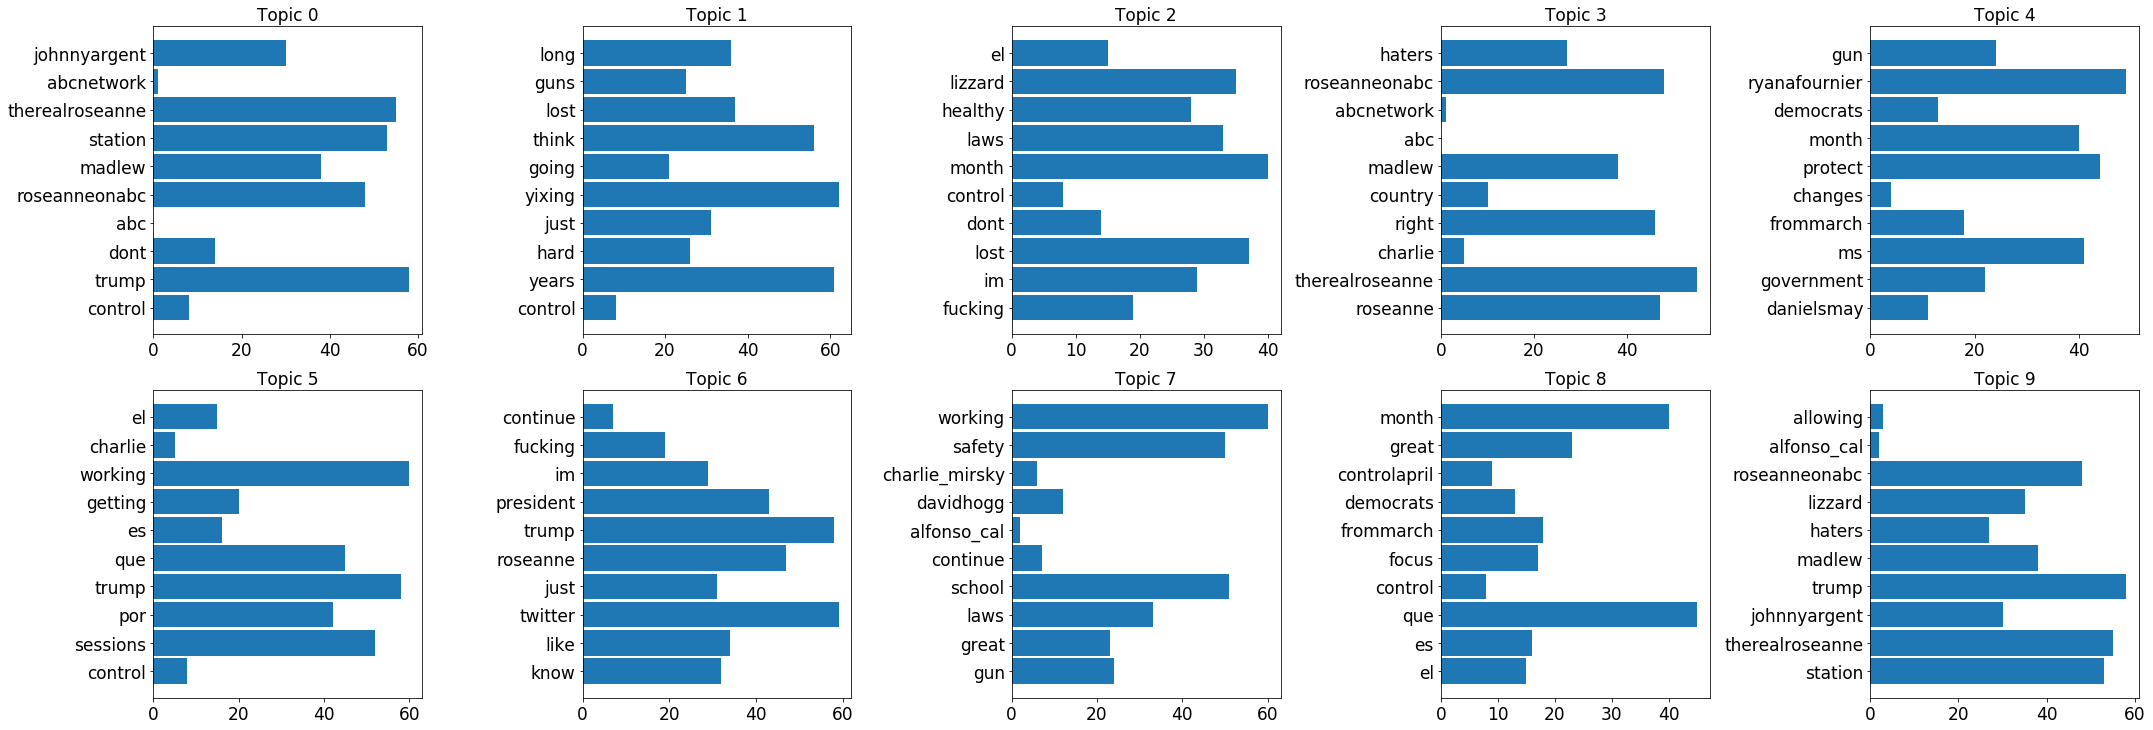

Dimensionality reduction...
Done


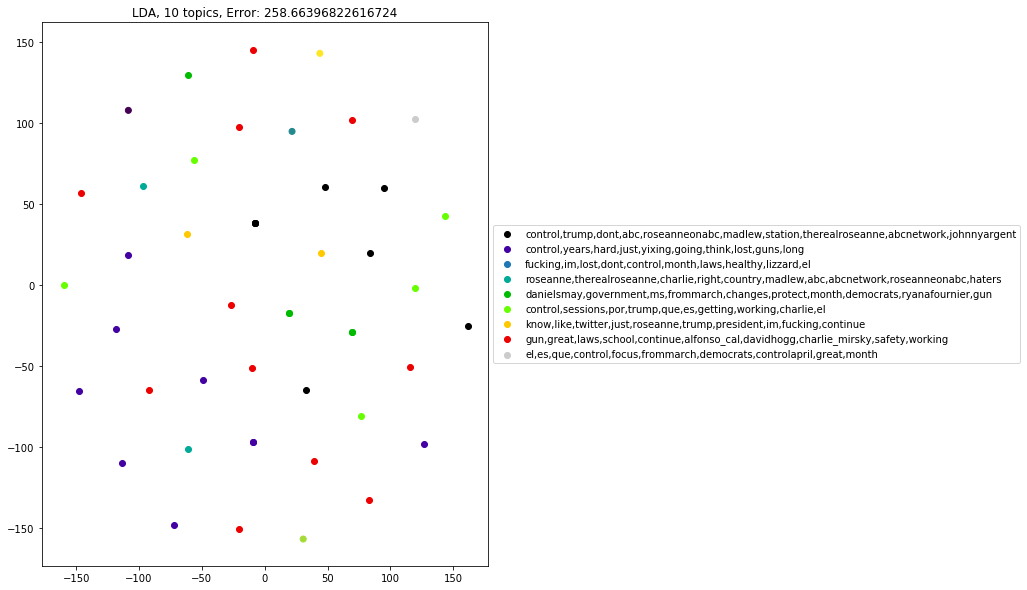

In [9]:
tweet_dataframe = pd.read_csv(
    # Cohen raid dataset. 147000 tweets or so
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_cohen_trump_FBI_raid_mueller_nda_corruption_corrupt_stormy.jsonl_converted_tweets.tsv", sep = '\t')
    # Small test set:
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_rights_guncontrol_converted_tweets.tsv", sep = '\t')
    # Large set with tsne and labels:
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_raid_reduced.tsv", sep = '\t')
    # Liberal set. About 3000 tweets
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_liberal_converted_tweets.tsv", sep = '\t')
    "~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_gun_control_converted_tweets.tsv", sep = '\t')
# Check the blank filtered_text
#print(tweet_dataframe['filtered_text'].isnull().sum())
# and remove if necessary
#tweet_dataframe = tweet_dataframe.dropna()

topics = 10

#tweet_dataframe, topics = nmf_analysis(tweet_dataframe, optimize = False, n_topics = topics) 
tweet_dataframe, topics = lda_analysis(tweet_dataframe, optimize = False, n_topics = topics)      

Test what exactly is going on with the null data:

In [3]:
tweet_dataframe = pd.read_csv(
    "~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_raid_reduced.tsv", sep = '\t')
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_rights_guncontrol_converted_tweets.tsv", sep = '\t')


In [4]:
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


def testing_df(data, text):
    cnt = 0
    a = np.where(data.isnull())
   
    #print("bad spot:", text.loc[a[0][0]])
def testing_tf(data):

    n_features = 1000 
    n_topics = 2
    n_top_words = 15

    tf_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features = n_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(data)
    tf_feature_names = tf_vectorizer.get_feature_names()



print(tweet_dataframe.shape)
print(tweet_dataframe.isnull().sum())
tweet_dataframe = tweet_dataframe.dropna()
#testing_df(tweet_dataframe['filtered_text'], tweet_dataframe['text'])
#print(tweet_dataframe.isnull().sum())
#testing_tf(tweet_dataframe['filtered_text'])

(146619, 7)
Unnamed: 0       0
Unnamed: 0.1     0
date             0
likes            0
retweets         0
text             0
filtered_text    0
dtype: int64


Running the model using Pipeline. Pipeline is a good way to test the model quicky.

In [10]:
from sklearn.pipeline import Pipeline

In [15]:
tweet_dataframe = pd.read_csv(
    #"~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_guns_rights_guncontrol_converted_tweets.tsv", sep = '\t')
    "~/Documents/Git/Twitter-Mining/streaming_tweets/data/streaming_liberal_converted_tweets.tsv", sep = '\t')

n_features = 1000 
n_topics = 4

cv = CountVectorizer(max_df = 0.95, min_df = 2, max_features = n_features, stop_words='english')
lda = LatentDirichletAllocation(n_components = n_topics, random_state=0)
pipe = Pipeline(steps=[('CountVectorizer', cv), ('LatentDirichletAllocation ', lda)])

# Contains prob for all topics
probabilities = pipe.fit_transform(tweet_dataframe['filtered_text'])
pipe.score(tweet_dataframe['filtered_text'])
probabilities_df = pd.DataFrame(probabilities).copy()

/home/timor/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Remove tweets with low probability of being in any topic

In [16]:

reduced_df = tweet_dataframe.copy()
probabilities_df.where(probabilities_df >.80, inplace = True)
        
probabilities_df.dropna(how='all', inplace = True)
#print(probabilities_df[0])
#print(probabilities_df.index)
reduced_df = reduced_df.loc[probabilities_df.index]

# this is problematic. explore more with tsne reduction, as it doesn't plot right in main script
probabilities[probabilities_df.index]



array([[ 0.02807295,  0.92155737,  0.02536657,  0.0250031 ],
       [ 0.07060256,  0.81317946,  0.06163048,  0.0545875 ],
       [ 0.02777875,  0.02777876,  0.91666338,  0.02777911],
       ..., 
       [ 0.02083417,  0.02092769,  0.02083438,  0.93740376],
       [ 0.93155113,  0.02277154,  0.02294465,  0.02273269],
       [ 0.94628747,  0.01793262,  0.0179224 ,  0.0178575 ]])

Display tweet most likely to be in a topic cluster, for each topic cluster

In [17]:

index = []
for i in range(n_topics):
    index.append(probabilities_df.iloc[:, i].idxmax())
    print("Most representative tweet:", tweet_dataframe.loc[index[i], 'text'], "\n")
    
    index_top5 = np.argsort(probabilities_df.loc[:, i])[:-6:-1]
    print(probabilities_df.loc[index_top5, i], "\n")
    print("Top 5 most representative tweets:\n", tweet_dataframe.loc[index_top5, 'text'], "\n")

Most representative tweet: RT @Stump_for_Trump: Hours after the Fake News Media went crazy over a report of Pres. Trump profiting from successful real estate ventures… 

 138   NaN
 310   NaN
-1     NaN
 166   NaN
-1     NaN
Name: 0, dtype: float64 

Top 5 most representative tweets:
  138    RT @NetizenTofa: Koordinator Jaringan Islam Li...
 310    RT @TrumpsDC: Isn't it funny how the liberal D...
-1                                                    NaN
 166    what a load of liberal crap. Obama did more da...
-1                                                    NaN
Name: text, dtype: object 

Most representative tweet: RT @isohappiIy: antes tw era muy liberal, la mayoría de las cosas era con humor y si ponías algo sobre lo que pensabas o te pasaba en la vi… 

-1           NaN
-1           NaN
-1           NaN
-1           NaN
 176    0.924986
Name: 1, dtype: float64 

Top 5 most representative tweets:
 -1                                                    NaN
-1                    

KeyError: 'None of [3607   -1\n3603   -1\n3602   -1\n3601   -1\n3599   -1\nName: 2, dtype: int64] are in the [index]'

Histograms of probability of a document being in a topic.

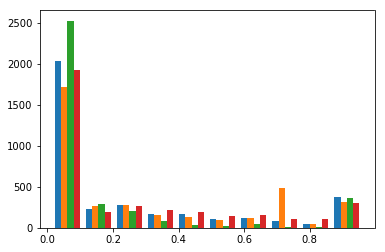

In [14]:
plt.hist(probabilities)
plt.show()

Include only tweets where the probability is higher than whatever looks good in the hist above.

The below visualization functions run in two ways: 
One, if the grid search function is being used to explore the number of topics. In this case gridsearch will automatically call visualize_mpl and save plots.
And two, if the grid search function is not being used, the model first must be built from a single topic in the cell above. Once the topic model has been built, run either visualize_plotly or mpl to plot. If plotly is being used, the number of colors/topics must be hardcoded in the function.

To use the plotly function, the colors have to be set by hand.

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot

In [8]:
def visualize_plotly(dataframe, topics): 
    """
    Visualize tsne data using plotly. The colors and number of topics must be hardcoded.
    """

    # oh wow very annoying problem
    # https://stackoverflow.com/questions/25792086/panda-merge-return-empty-dataframe
    df_palette = pd.DataFrame([
            [0, '#C03028'],
            [1, '#F08030'],
            [2, '#6890F0'],
            [3, '#78C850'],
            [4, '#A890F0'],
            [5, '#A040A0'],
            [6, '#F8D030'],
            [7, '#E0C068'],
            [8, '#F85888'],
            [9, '#B8A038']])
            #[10, '#98D8D8']])
            
            #[11, '#A8B820'],
            #[12, '#7038F8'],
            #[13, '#705898'],
            #[14, '#705848'],
            #[15, '#B8B8D0'],
            #[16, '#A8A878'],
            #[17, '#EE99AC']])
            
    df_palette.columns = ['labels', 'typecolor']
    dataframe.merge(df_palette, on = 'labels')

    plot_list = []
    
    for idx, (label, color) in df_palette.iterrows():
   
        # Select data that corresponds to 1 topic
        df_filter = dataframe[dataframe['labels'] == label]

        # create a scatter object for each topic
        scatter = dict(
            mode = "markers",
            name = "{}".format(topics[label]), # returns label
            type = "scatter",
            text =  df_filter['text'],
            showlegend = True,
            #legendgroup = "stuff", # can use this to group things in the legend I think...
            x =  df_filter['x'], y =  df_filter['y'],
            marker = dict( 
                #size=10, 
                color = color)) 
                #line = dict(
                #width = 3)))
    
        plot_list.append(scatter) 
    
    # need this to override plotly non-iterative settings
    empty_axis = dict(zeroline=False, showaxeslabels=False, showticklabels=False, title='')
    layout = dict(
                scene = dict(
                    xaxis = empty_axis,
                    yaxis = empty_axis,
                    ),
                hovermode = 'closest',
                showlegend = True)

    fig = dict(data = plot_list, layout = layout)
    plot_url = py.plot(fig)
    
    
def visualize_mpl(dataframe, topics, error = None, method = None):
    """
    Plot tsne data using matplotlib. When calling this function, no error or method need be
    provided. These arguments are only used by gridsearch.
    """
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(set(pd.Series(dataframe['labels'])))))
    # https://matplotlib.org/examples/color/colormaps_reference.html

    fig, ax = plt.subplots(figsize = (10, 10))
    
    if error == None:
        ax.set_title('{0} topics'.format(len(topics)))
    else:
        ax.set_title('{0}, {1} topics, Error: {2}'.format(method, len(topics), error))

    # Thank you!:
    #https://stackoverflow.com/questions/46819664/how-to-add-labels-to-t-sne-in-python
    # https://www.kaggle.com/tilii7/t-sne-visualization/code

    for i, color in zip(range(len(topics)), colors):
        
        ax.scatter(dataframe.loc[dataframe['labels'] == i, 'x'],
                   dataframe.loc[dataframe['labels'] == i, 'y'], 
                   label = topics[i], c = color)
  
    # https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
    if method != None: # method only != none when gridsearch runs
        fig.savefig('/home/timor/Documents/Git/Twitter-Mining/streaming_tweets/data/{0}_topics_{1}.png'.format(len(topics), method))
    
    plt.close()

If model has been generated, and tsne and label columns have been added, run just the visualization functions below to see the clusters

In [36]:
visualize_plotly(tweet_dataframe, topics)
#visualize_mpl(tweet_dataframe, topics)